In [145]:
from pyspark import SparkContext
import findspark
import numpy as np

sc = SparkContext("local[*]", "Practica1")


## Ejercicio 3

In [16]:
def readFile (filename): 
    '''Arguments: 
    filename – name of the spam dataset file 
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y) 
    Y -- Train labels (0 if normal traffic, 1 if botnet)  
    m rows: number of examples (m) 
    Returns: 
    An RDD containing the data of filename. Each example (row) of the file 
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).  
    “X” is an array containing the 11 features (float number) of an example  
    “y” is the 12th column of an example (integer 0/1) '''
    result = sc.textFile(filename)
    map_result = result.map(lambda row: [float(x) for x in row.split(",")])
    rdd_xy = map_result.map(lambda row: (row[:11],row[11]))
    return rdd_xy

In [17]:
# Prueba
data=readFile("./botnet_reduced_10k_l.csv")
data.take(2)

[([3545.3018916840147,
   3198.0139469522546,
   80.00015469454229,
   1.0000019205086303,
   444960086.4643011,
   476.8073064086366,
   12.999999992936175,
   -7.710424743123667e-09,
   87.00000148917339,
   19099430.15956688,
   2468368394.7593513],
  0.0),
 ([-1.21308761436012e-06,
   7.999989079213265,
   65499.99887793755,
   0.9999997452701503,
   61.99988768910407,
   69.99980788311223,
   11.999999995904211,
   -2.35688187855132e-08,
   8.00000498340475,
   2468369617.006896,
   2468368392.7377276],
  1.0)]

In [18]:
rows_rdd = data.map(lambda line: line[0])
print(rows_rdd.take(1))
print()
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
print(cols_rdd.take(5))
print()
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
print(group_rdd.take(1))
print()
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
print(mean_rdd.collect())
print()
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))

[[3545.3018916840147, 3198.0139469522546, 80.00015469454229, 1.0000019205086303, 444960086.4643011, 476.8073064086366, 12.999999992936175, -7.710424743123667e-09, 87.00000148917339, 19099430.15956688, 2468368394.7593513]]

[(0, (3545.3018916840147, 12569165.503178252, 1)), (1, (3198.0139469522546, 10227293.204901138, 1)), (2, (80.00015469454229, 6400.024751150697, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (444960086.4643011, 1.979894785463183e+17, 1))]



[(0, (12803754.219009735, 42093817354.54738, 10000))]

[(0, (1280.3754219009734, np.float64(1603.1283524554865))), (2, (6731.840347965938, np.float64(16143.570758867212))), (4, (121275247.72856577, np.float64(231897601.15814963))), (6, (9.076034067369386, np.float64(5.298563791442084))), (8, (123.35245169147989, np.float64(90.51210108183089))), (10, (2265313681.7355, np.float64(1295737133.3017318))), (1, (21567.839327212547, np.float64(24184.80186045207))), (3, (60997.64689050441, np.float64(132772.42926971006))), (5, (15681843.675553748, np.float64(44314898.97700508))), (7, (1.8753065233820918, np.float64(2.096302756194286))), (9, (2123967949.925293, np.float64(723225092.7000036)))]



In [19]:
def normalize (RDD_Xy): 
    '''Arguments: 
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    Returns: 
    An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1) '''
    def map_normalize (RDD_Xy): 
        result = []
        x, y = RDD_Xy
        var = broadcast_var.value
        for i, x in enumerate(x):
             mean_aux, std_aux = var[i]
             if(std_aux!=0):
                 result.append((x - mean_aux)/std_aux)
             else:
                 result.append(0.0)
        return result, y
        
    rdd_norm = RDD_Xy.map(map_normalize)
    return rdd_norm

In [20]:
rdd_norm = normalize(data)
print(rdd_norm.take(2))

[([np.float64(1.4128166757913607), np.float64(-0.7595607144625546), np.float64(-0.4120426820452796), np.float64(-0.45940747807420984), np.float64(1.3958093448107236), np.float64(-0.3538621824769221), np.float64(0.7405716114816884), np.float64(-0.8945780973436418), np.float64(-0.4016308291135645), np.float64(-2.9103919941544856), np.float64(0.15670980463949324)], 0.0), ([np.float64(-0.7986730576830795), np.float64(-0.8914623101952646), np.float64(3.640344469496744), np.float64(-0.45940747809059307), np.float64(-0.5229686944711893), np.float64(-0.35387136240303985), np.float64(0.551841224079898), np.float64(-0.8945781049085767), np.float64(-1.2744422605302952), np.float64(0.4762025966160194), np.float64(0.156709803079282)], 1.0)]


In [21]:
# QUITAR: COMPROBACION SI DA 1 PARA CADA INDICE LA SUMA
import math
# comprobar que cada columna queda ~ media 0 y std 1
x_norm = rdd_norm.map(lambda xy: xy[0])

check = (
    x_norm
    .flatMap(lambda row: [(i, (v, v*v, 1)) for i, v in enumerate(row)])
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], a[2]+b[2]))
    .mapValues(lambda t: (
        t[0]/t[2],  # mean
        math.sqrt(max((t[1]/t[2]) - (t[0]/t[2])**2, 0.0))  # std
    ))
    .collect()
)

print(sorted(check, key=lambda x: x[0]))
# medias ~ 0, std ~ 1 (salvo redondeo numérico)

[(0, (np.float64(1.737507915322567e-14), 1.0000000000000009)), (1, (np.float64(9.445244586459011e-15), 0.999999999999989)), (2, (np.float64(-1.3302070556164836e-14), 0.9999999999999883)), (3, (np.float64(2.3310064989345848e-14), 0.9999999999999803)), (4, (np.float64(-1.3432810419544694e-15), 0.9999999999999976)), (5, (np.float64(-4.6409098786170944e-15), 1.0000000000000069)), (6, (np.float64(1.645616976020392e-15), 0.999999999999988)), (7, (np.float64(-1.1839595970286609e-14), 1.000000000000001)), (8, (np.float64(3.481659405224491e-17), 0.99999999999998)), (9, (np.float64(2.1675106154361856e-14), 0.9999999999998741)), (10, (np.float64(-2.4653701302668196e-14), 1.0000000000000524))]


In [26]:
# PRIMERA PRUEBA TRAIN
import numpy as np
import math

def sigmoid(z):
    if z >= 0:
        ez = math.exp(-z)
        return 1.0 / (1.0 + ez)
    else:
        ez = math.exp(z)
        return ez / (1.0 + ez)

def _sample_grad(xy, w, b):
    X, y = xy
    X = np.asarray(X, dtype=np.float64)
    y = float(y)

    z = float(np.dot(w, X) + b)
    y_hat = sigmoid(z)
    diff = y_hat - y

    grad_w = diff * X      # vector (11,)
    grad_b = diff          # escalar

    loss = -(y * math.log(y_hat)+(1-y)*math.log(1-y_hat))
    return (grad_w, grad_b, loss)

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy
    
    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        
        print(f"Loss en iteracion {i}: {J}")

    return [w, b]

In [27]:
def accuracy (w, b, RDD_Xy): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    RDD_Xy – RDD containing examples to be predicted  
    Returns: 
    accuracy -- the number of predictions that are correct divided by the number         
    of records (examples) in RDD_xy.  
    Predict function can be used for predicting a single example'''
    pred_ok = RDD_Xy.map(
            lambda xy: 1 if predict(w, b, xy[0]) == int(xy[1]) else 0
        )
    
    correct = pred_ok.reduce(lambda a, c: a + c)
    total = RDD_Xy.count()
    return correct / total if total > 0 else 0.0

In [28]:
def predict (w, b, X): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    X – Example to be predicted  
     
    Returns: 
    Y_pred – a value (0/1) corresponding to the prediction of X '''
    threshold=0.5
    z = float(np.dot(np.asarray(w, dtype=float), np.asarray(X, dtype=float)) + float(b))
    p = sigmoid(z)
    return 1 if p >= threshold else 0

In [29]:
# read data
data=readFile("./botnet_reduced_10k_l.csv")
# standarize
data = normalize(data)

ws = train(data,20,5,1.5)
print(ws)
w,b = ws
acc = accuracy(w,b,data)
print("acc:",acc)

Loss en iteracion 0: 1.1667384170095085
Loss en iteracion 1: 0.3295914676296574
Loss en iteracion 2: 0.547577458385063
Loss en iteracion 3: 0.3677081641331553
Loss en iteracion 4: 0.5196666284712211
Loss en iteracion 5: 0.3727539984774305
Loss en iteracion 6: 0.5041872950664801
Loss en iteracion 7: 0.3756715744798257
Loss en iteracion 8: 0.4939463105643449
Loss en iteracion 9: 0.37785888092565517
Loss en iteracion 10: 0.4864085353823972
Loss en iteracion 11: 0.3797167454923392
Loss en iteracion 12: 0.48051636433800904
Loss en iteracion 13: 0.3813672707588669
Loss en iteracion 14: 0.4757328406742082
Loss en iteracion 15: 0.38286051757874084
Loss en iteracion 16: 0.4717457397723028
Loss en iteracion 17: 0.38422533488182015
Loss en iteracion 18: 0.46835635646416446
Loss en iteracion 19: 0.385482551209114
[array([-0.12685943, -0.41603846, -0.14626668, -0.13895894, -0.53917612,
        0.35579208,  0.12845404, -0.5010944 ,  0.28917901,  0.30625408,
        0.28008346]), -0.06843487577590675

## Configuracion utilizada

In [5]:
%pip install psutil


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import psutil

physical_cores = psutil.cpu_count(logical=False)
print(f"Physical cores: {physical_cores}")

Physical cores: 4


## EJERCICIO 3.1

In [ ]:
def train_dict(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A tuple with dict and an array'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy
    
    dict_iterations = {}
    
    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        dict_iterations[i] = J
        
        print(f"Loss en iteracion {i}: {J}")

    return dict_iterations, [w, b]

In [56]:
sc.stop()

In [62]:
from pyspark import SparkContext
import findspark
import numpy as np
sc = SparkContext("local[*]", "Practica1")
# read data
data=readFile("./botnet_reduced_10k_l.csv")
rows_rdd = data.map(lambda line: line[0])
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))

# standarize
#learning_rates=[1,2,3,4,5] 
learning_rates=[0.5,1,1.5,2,2.5,3,3.5] 
dict_result = {}

for i in learning_rates:
    # read data
    data=readFile("./botnet_reduced_10k_l.csv")
    # standarize
    data = normalize(data)
    ws = train_dict(data,10,i,1.5)
    dict_iterations, (w,b) = ws
    acc = accuracy(w,b,data)
    dict_result[i] = dict_iterations

        
print(dict_result)
sc.stop()

Loss en iteracion 0: 0.6958770592707986
Loss en iteracion 1: 0.5813982698863603
Loss en iteracion 2: 0.5207371554084465
Loss en iteracion 3: 0.4860669085847379
Loss en iteracion 4: 0.46485225743856085
Loss en iteracion 5: 0.45117073552775067
Loss en iteracion 6: 0.4419861148310643
Loss en iteracion 7: 0.43562393943842237
Loss en iteracion 8: 0.43110450961371843
Loss en iteracion 9: 0.42782684056932146
Loss en iteracion 0: 0.7102450498829936
Loss en iteracion 1: 0.5131191921479608
Loss en iteracion 2: 0.46193063777645404
Loss en iteracion 3: 0.4414077158307114
Loss en iteracion 4: 0.43139431403127837
Loss en iteracion 5: 0.42595049208765023
Loss en iteracion 6: 0.42277652881286737
Loss en iteracion 7: 0.42083149681198895
Loss en iteracion 8: 0.41959374079951306
Loss en iteracion 9: 0.4187822952371615


Loss en iteracion 0: 0.7341005250015485
Loss en iteracion 1: 0.4679244107639831
Loss en iteracion 2: 0.437885262216135
Loss en iteracion 3: 0.42709256487965797
Loss en iteracion 4: 0.4223082650690898
Loss en iteracion 5: 0.4199368862101589
Loss en iteracion 6: 0.4186742903081265
Loss en iteracion 7: 0.417968385090474
Loss en iteracion 8: 0.4175600234553712
Loss en iteracion 9: 0.4173180076556023


Loss en iteracion 0: 0.7674434846264633
Loss en iteracion 1: 0.4358619046437262
Loss en iteracion 2: 0.42495811863980987
Loss en iteracion 3: 0.42078152290178894
Loss en iteracion 4: 0.4188144193324227
Loss en iteracion 5: 0.41786451806008235
Loss en iteracion 6: 0.4174003933580193
Loss en iteracion 7: 0.41717075316356866
Loss en iteracion 8: 0.41705570642436024
Loss en iteracion 9: 0.4169973932866541


Loss en iteracion 0: 0.8102739287577378
Loss en iteracion 1: 0.41150078266802764
Loss en iteracion 2: 0.4172822860345055
Loss en iteracion 3: 0.41808569617555436
Loss en iteracion 4: 0.41742728767619774
Loss en iteracion 5: 0.4171380833714737
Loss en iteracion 6: 0.4170186751636479
Loss en iteracion 7: 0.4169695667723072
Loss en iteracion 8: 0.41694930783640044
Loss en iteracion 9: 0.41694089367915443


Loss en iteracion 0: 0.8625918573953724
Loss en iteracion 1: 0.3916251465864969
Loss en iteracion 2: 0.41481098502418945
Loss en iteracion 3: 0.4167443204431809
Loss en iteracion 4: 0.41695781313339636
Loss en iteracion 5: 0.4169418006578759
Loss en iteracion 6: 0.41693780284699966
Loss en iteracion 7: 0.41693514883365507
Loss en iteracion 8: 0.4169346665488405
Loss en iteracion 9: 0.4169345845354787


Loss en iteracion 0: 0.9243972705393666
Loss en iteracion 1: 0.37425129393091533
Loss en iteracion 2: 0.41994461443740383
Loss en iteracion 3: 0.4135160454670317
Loss en iteracion 4: 0.41814471384451013
Loss en iteracion 5: 0.4164137484438912
Loss en iteracion 6: 0.41712922144638886
Loss en iteracion 7: 0.41685402651407244
Loss en iteracion 8: 0.41696510065818326
Loss en iteracion 9: 0.41692218953881155
{0.5: {0: 0.6958770592707986, 1: 0.5813982698863603, 2: 0.5207371554084465, 3: 0.4860669085847379, 4: 0.46485225743856085, 5: 0.45117073552775067, 6: 0.4419861148310643, 7: 0.43562393943842237, 8: 0.43110450961371843, 9: 0.42782684056932146}, 1: {0: 0.7102450498829936, 1: 0.5131191921479608, 2: 0.46193063777645404, 3: 0.4414077158307114, 4: 0.43139431403127837, 5: 0.42595049208765023, 6: 0.42277652881286737, 7: 0.42083149681198895, 8: 0.41959374079951306, 9: 0.4187822952371615}, 1.5: {0: 0.7341005250015485, 1: 0.4679244107639831, 2: 0.437885262216135, 3: 0.42709256487965797, 4: 0.422308


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


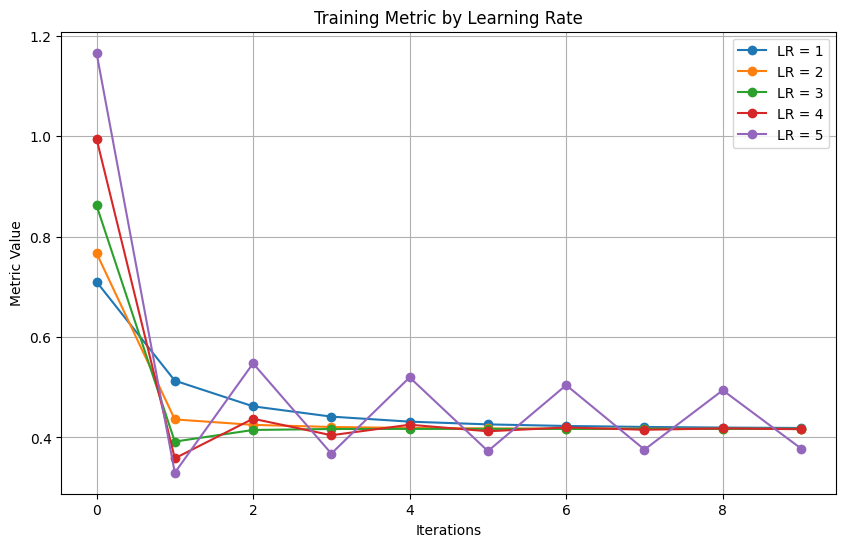

In [61]:
%pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for lr, metrics in dict_result.items():
    iterations = list(metrics.keys())
    values = list(metrics.values())
    plt.plot(iterations, values, marker='o', label=f'LR = {lr}')

plt.title('Training Metric by Learning Rate')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.savefig('plot.png')


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


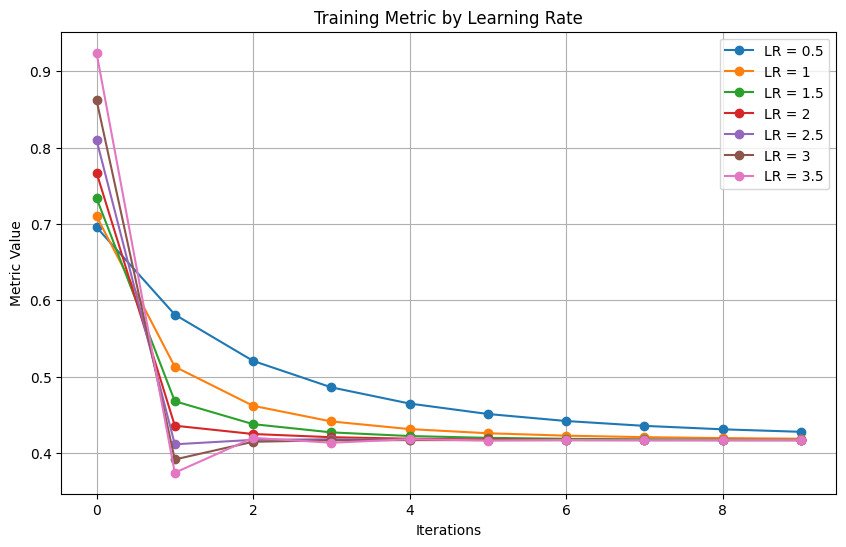

In [63]:
%pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for lr, metrics in dict_result.items():
    iterations = list(metrics.keys())
    values = list(metrics.values())
    plt.plot(iterations, values, marker='o', label=f'LR = {lr}')

plt.title('Training Metric by Learning Rate')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.savefig('plot.png')

# EJERCICIO 3.1 b

In [64]:
def train_dict(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A tuple with dict and an array'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy
    
    dict_iterations = {}
    
    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        dict_iterations[i] = J
        
        print(f"Loss en iteracion {i}: {J}")

    return dict_iterations, [w, b]

In [68]:
sc.stop()

In [69]:
from pyspark import SparkContext
import findspark
import numpy as np
sc = SparkContext("local[*]", "Practica1")
# read data
data=readFile("./botnet_reduced_10k_l.csv")
rows_rdd = data.map(lambda line: line[0])
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))

# standarize
lambda_reg=[1,2,3,4,5] 
dict_result = {}

for i in lambda_reg:
    # read data
    data=readFile("./botnet_reduced_10k_l.csv")
    # standarize
    data = normalize(data)
    ws = train_dict(data,10,1.5,i)
    dict_iterations, (w,b) = ws
    acc = accuracy(w,b,data)
    dict_result[i] = dict_iterations

        
print(dict_result)
sc.stop()

Loss en iteracion 0: 0.7197352871733655
Loss en iteracion 1: 0.45111767733685637
Loss en iteracion 2: 0.41196576253493083
Loss en iteracion 3: 0.396723275350825
Loss en iteracion 4: 0.3894019684174058
Loss en iteracion 5: 0.3854843315864629
Loss en iteracion 6: 0.38323557957381893
Loss en iteracion 7: 0.38187721690706594
Loss en iteracion 8: 0.38102399183920194
Loss en iteracion 9: 0.3804714187878602


Loss en iteracion 0: 0.7484416922792942
Loss en iteracion 1: 0.48033779009772226
Loss en iteracion 2: 0.45805764631566503
Loss en iteracion 3: 0.45055085645497256
Loss en iteracion 4: 0.4474675873825442
Loss en iteracion 5: 0.4460597195598327
Loss en iteracion 6: 0.4453750472905516
Loss en iteracion 7: 0.4450287560770221
Loss en iteracion 8: 0.44484903571396683
Loss en iteracion 9: 0.44475404384333544


Loss en iteracion 0: 0.7770542854825877
Loss en iteracion 1: 0.4936237831690591
Loss en iteracion 2: 0.4883960429912778
Loss en iteracion 3: 0.48575071344651205
Loss en iteracion 4: 0.4846870909564366
Loss en iteracion 5: 0.4842869885350524
Loss en iteracion 6: 0.48413591217025986
Loss en iteracion 7: 0.48407758625834524
Loss en iteracion 8: 0.48405441193817633
Loss en iteracion 9: 0.4840448822576867


Loss en iteracion 0: 0.8055780073814732
Loss en iteracion 1: 0.4942396772132167
Loss en iteracion 2: 0.5143839690279772
Loss en iteracion 3: 0.5116940129175607
Loss en iteracion 4: 0.5115684457323751
Loss en iteracion 5: 0.5114904964669581
Loss en iteracion 6: 0.511473670310374
Loss en iteracion 7: 0.511468149665651
Loss en iteracion 8: 0.5114661887179169
Loss en iteracion 9: 0.51146530708835
Loss en iteracion 0: 0.834017798574178
Loss en iteracion 1: 0.4854274621400916
Loss en iteracion 2: 0.5436191612312555
Loss en iteracion 3: 0.5291351515200051
Loss en iteracion 4: 0.532759631456464
Loss en iteracion 5: 0.5318178601125447
Loss en iteracion 6: 0.5320566030312598
Loss en iteracion 7: 0.5319939475041958
Loss en iteracion 8: 0.5320092685385134
Loss en iteracion 9: 0.5320048405107944
{1: {0: 0.7197352871733655, 1: 0.45111767733685637, 2: 0.41196576253493083, 3: 0.396723275350825, 4: 0.3894019684174058, 5: 0.3854843315864629, 6: 0.38323557957381893, 7: 0.38187721690706594, 8: 0.381023991


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


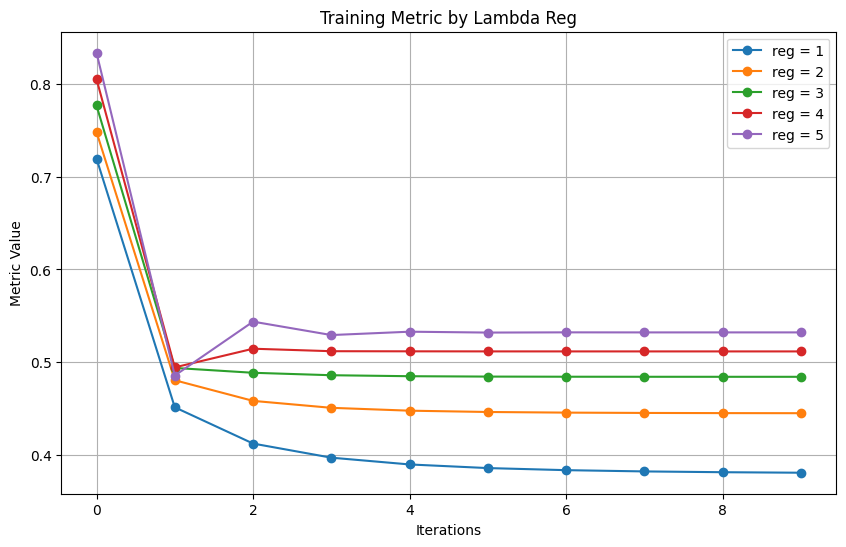

In [70]:
%pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for lr, metrics in dict_result.items():
    iterations = list(metrics.keys())
    values = list(metrics.values())
    plt.plot(iterations, values, marker='o', label=f'reg = {lr}')

plt.title('Training Metric by Lambda Reg')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.savefig('plot.png')

# EJERCICIO 3.2

In [153]:
sc.stop()

In [154]:
from pyspark import SparkContext
import findspark
import numpy as np
from time import perf_counter
from pyspark import SparkContext
import findspark
import numpy as np
sc = SparkContext("local[*]", "Practica1")


In [155]:
def readFile (filename): 
    '''Arguments: 
    filename – name of the spam dataset file 
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y) 
    Y -- Train labels (0 if normal traffic, 1 if botnet)  
    m rows: number of examples (m) 
    Returns: 
    An RDD containing the data of filename. Each example (row) of the file 
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).  
    “X” is an array containing the 11 features (float number) of an example  
    “y” is the 12th column of an example (integer 0/1) '''
    result = sc.textFile(filename)
    map_result = result.map(lambda row: [float(x) for x in row.split(",")])
    rdd_xy = map_result.map(lambda row: (row[:11],row[11]))
    return rdd_xy

In [156]:
data=readFile("./botnet_reduced_10k_l.csv")


In [157]:
rows_rdd = data.map(lambda line: line[0])
print(rows_rdd.take(1))
print()
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
print(cols_rdd.take(5))
print()
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
print(group_rdd.take(1))
print()
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
print(mean_rdd.collect())
print()
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))

[[3545.3018916840147, 3198.0139469522546, 80.00015469454229, 1.0000019205086303, 444960086.4643011, 476.8073064086366, 12.999999992936175, -7.710424743123667e-09, 87.00000148917339, 19099430.15956688, 2468368394.7593513]]

[(0, (3545.3018916840147, 12569165.503178252, 1)), (1, (3198.0139469522546, 10227293.204901138, 1)), (2, (80.00015469454229, 6400.024751150697, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (444960086.4643011, 1.979894785463183e+17, 1))]

[(0, (12803754.219009735, 42093817354.54738, 10000))]

[(0, (1280.3754219009734, np.float64(1603.1283524554865))), (2, (6731.840347965938, np.float64(16143.570758867212))), (4, (121275247.72856577, np.float64(231897601.15814963))), (6, (9.076034067369386, np.float64(5.298563791442084))), (8, (123.35245169147989, np.float64(90.51210108183089))), (10, (2265313681.7355, np.float64(1295737133.3017318))), (1, (21567.839327212547, np.float64(24184.80186045207))), (3, (60997.64689050441, np.float64(132772.42926971006))), (5, (1

In [158]:
def normalize (RDD_Xy): 
    '''Arguments: 
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    Returns: 
    An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1) '''
    def map_normalize (RDD_Xy): 
        result = []
        x, y = RDD_Xy
        var = broadcast_var.value
        for i, x in enumerate(x):
             mean_aux, std_aux = var[i]
             if(std_aux!=0):
                 result.append((x - mean_aux)/std_aux)
             else:
                 result.append(0.0)
        return result, y
        
    rdd_norm = RDD_Xy.map(map_normalize)
    return rdd_norm

In [159]:
# PRIMERA PRUEBA TRAIN
import numpy as np
import math

def sigmoid(z):
    if z >= 0:
        ez = math.exp(-z)
        return 1.0 / (1.0 + ez)
    else:
        ez = math.exp(z)
        return ez / (1.0 + ez)

def _sample_grad(xy, w, b):
    X, y = xy
    X = np.asarray(X, dtype=np.float64)
    y = float(y)

    z = float(np.dot(w, X) + b)
    y_hat = sigmoid(z)
    diff = y_hat - y

    grad_w = diff * X      # vector (11,)
    grad_b = diff          # escalar

    loss = -(y * math.log(y_hat)+(1-y)*math.log(1-y_hat))
    return (grad_w, grad_b, loss)

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy

    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        
        print(f"Loss en iteracion {i}: {J}")

    return [w, b]

In [160]:
def accuracy (w, b, RDD_Xy): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    RDD_Xy – RDD containing examples to be predicted  
    Returns: 
    accuracy -- the number of predictions that are correct divided by the number         
    of records (examples) in RDD_xy.  
    Predict function can be used for predicting a single example'''
    pred_ok = RDD_Xy.map(
            lambda xy: 1 if predict(w, b, xy[0]) == int(xy[1]) else 0
        )
    
    correct = pred_ok.reduce(lambda a, c: a + c)
    total = RDD_Xy.count()
    return correct / total if total > 0 else 0.0

In [161]:
def predict (w, b, X): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    X – Example to be predicted  
     
    Returns: 
    Y_pred – a value (0/1) corresponding to the prediction of X '''
    threshold=0.5
    z = float(np.dot(np.asarray(w, dtype=float), np.asarray(X, dtype=float)) + float(b))
    p = sigmoid(z)
    return 1 if p >= threshold else 0

In [163]:
sc.stop()

In [164]:
# read data
result = {}
for i in range(1, 11): # MODIFICAR CUANDO TENGAMOS LA EJECUCION FINAL (CORES + 3)
    sc = SparkContext(f"local[{i}]", f"Prueba_{i}")
    t0 = perf_counter()
    data=readFile("./botnet_reduced_10k_l.csv").repartition(i)
    print(data.getNumPartitions())
    rows_rdd = data.map(lambda line: line[0])
    print(rows_rdd.take(1))
    print()
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    print(cols_rdd.take(5))
    print()
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    print(group_rdd.take(1))
    print()
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    print(mean_rdd.collect())
    print()
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train(data,10,1.5,0.0)
    print(ws)
    w,b = ws
    acc = accuracy(w,b,data)
    print("acc:",acc)
    time = perf_counter() - t0
    result[i] = time
    sc.stop()
print(result)

1


[[3545.3018916840147, 3198.0139469522546, 80.00015469454229, 1.0000019205086303, 444960086.4643011, 476.8073064086366, 12.999999992936175, -7.710424743123667e-09, 87.00000148917339, 19099430.15956688, 2468368394.7593513]]

[(0, (3545.3018916840147, 12569165.503178252, 1)), (1, (3198.0139469522546, 10227293.204901138, 1)), (2, (80.00015469454229, 6400.024751150697, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (444960086.4643011, 1.979894785463183e+17, 1))]

[(0, (12803754.219010336, 42093817354.54772, 10000))]

[(0, (1280.3754219010336, np.float64(1603.1283524554492))), (1, (21567.839327213467, np.float64(24184.801860451298))), (2, (6731.840347965561, np.float64(16143.570758867018))), (3, (60997.64689050794, np.float64(132772.42926970878))), (4, (121275247.72856677, np.float64(231897601.15815005))), (5, (15681843.675553631, np.float64(44314898.9770038))), (6, (9.076034067370005, np.float64(5.298563791440585))), (7, (1.875306523382018, np.float64(2.0963027561943175))), (8, (

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3545.3018916840147, 3198.0139469522546, 80.00015469454229, 1.0000019205086303, 444960086.4643011, 476.8073064086366, 12.999999992936175, -7.710424743123667e-09, 87.00000148917339, 19099430.15956688, 2468368394.7593513]]

[(0, (3545.3018916840147, 12569165.503178252, 1)), (1, (3198.0139469522546, 10227293.204901138, 1)), (2, (80.00015469454229, 6400.024751150697, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (444960086.4643011, 1.979894785463183e+17, 1))]

[(0, (12803754.219010105, 42093817354.54753, 10000))]

[(0, (1280.3754219010104, np.float64(1603.1283524554615))), (3, (60997.64689050493, np.float64(132772.4292697098))), (6, (9.076034067369363, np.float64(5.29856379144222))), (9, (2123967949.9252985, np.float64(723225092.6999626))), (1, (21567.839327212518, np.float64(24184.801860452062))), (4, (121275247.72856545, np.float64(231897601.15815043))), (7, (1.8753065233821056, np.float64(2.096302756194312))), (10, (2265313681.7354712, np.float64(1295737133.3017907))), (2, 

[[-1.21308761436012e-06, 2529.5994634859253, -4.410370297591726e-05, 0.9999997452701503, 138732465.28180686, 70.99999101711273, 11.999999995904211, -2.35688187855132e-08, 8.00000498340475, 2468369572.9931583, 3757374480.752986]]

[(0, (-1.21308761436012e-06, 1.471581560113927e-12, 1)), (1, (2529.5994634859253, 6398873.445668281, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138732465.28180686, 1.9246696923167744e+16, 1))]

[(0, (12803754.21901014, 42093817354.54783, 10000))]

[(0, (1280.375421901014, np.float64(1603.128352455468))), (4, (121275247.72856438, np.float64(231897601.15815097))), (8, (123.35245169147872, np.float64(90.51210108183182))), (1, (21567.83932721258, np.float64(24184.801860451935))), (5, (15681843.675553959, np.float64(44314898.97700532))), (9, (2123967949.925301, np.float64(723225092.6999605))), (2, (6731.8403479656845, np.float64(16143.570758867136))), (6, (9.076034067369436, np.float64(5.298

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219010137, 42093817354.54809, 10000))]

[(0, (1280.3754219010136, np.float64(1603.1283524554765))), (5, (15681843.675553974, np.float64(44314898.97700507))), (10, (2265313681.735475, np.float64(1295737133.3017914))), (1, (21567.839327212645, np.float64(24184.80186045185))), (6, (9.076034067369497, np.float64(5.298563791442009))), (2, (6731.840347965678, np.float64(16143.57075886716))), (7, (1.8753065233821014, np.float64(2.0963027561943157))), (3, (60997.646890508244, np.float64(132772.4292

[[-1.21308761436012e-06, 2529.5994634859253, -4.410370297591726e-05, 0.9999997452701503, 138732465.28180686, 70.99999101711273, 11.999999995904211, -2.35688187855132e-08, 8.00000498340475, 2468369572.9931583, 3757374480.752986]]

[(0, (-1.21308761436012e-06, 1.471581560113927e-12, 1)), (1, (2529.5994634859253, 6398873.445668281, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138732465.28180686, 1.9246696923167744e+16, 1))]

[(0, (12803754.21901014, 42093817354.548035, 10000))]

[(0, (1280.375421901014, np.float64(1603.1283524554744))), (6, (9.076034067369518, np.float64(5.298563791441922))), (1, (21567.839327212703, np.float64(24184.80186045182))), (7, (1.8753065233820894, np.float64(2.0963027561943224))), (2, (6731.840347965691, np.float64(16143.570758867165))), (8, (123.35245169147916, np.float64(90.51210108182997))), (3, (60997.6468905082, np.float64(132772.42926970895))), (9, (2123967949.9253044, np.float64(7232

[[0.0006999386757797765, 61897.98817283135, 53.000260213743786, 499897.4493343788, 262.99924185046257, 82.99988759205826, 13.986787817919089, 5.000000032871429, 7.999999237579246, 1566353357.5387971, 1483612272.011435]]

[(0, (0.0006999386757797765, 4.899141498523472e-07, 1)), (1, (61897.98817283135, 3831360939.8439693, 1)), (2, (53.000260213743786, 2809.0275827245523, 1)), (3, (499897.4493343788, 249897459851.01785, 1)), (4, (262.99924185046257, 69168.6012139181, 1))]

[(0, (12803754.219010115, 42093817354.54798, 10000))]

[(0, (1280.3754219010116, np.float64(1603.1283524554744))), (7, (1.8753065233820774, np.float64(2.096302756194328))), (1, (21567.839327212718, np.float64(24184.80186045182))), (8, (123.35245169147973, np.float64(90.51210108182858))), (2, (6731.840347965698, np.float64(16143.570758867158))), (9, (2123967949.9253063, np.float64(723225092.6999432))), (3, (60997.64689050814, np.float64(132772.42926970898))), (10, (2265313681.735472, np.float64(1295737133.3018057))), (4,

Loss en iteracion 7: 0.2375111606028084
Loss en iteracion 8: 0.22999599675012614
Loss en iteracion 9: 0.22381166695972574
[array([-0.30372989, -0.82410725, -0.32764508, -0.18718418, -1.14532131,
        0.74152177,  0.17930694, -1.09138574,  0.47564036,  0.66662877,
        0.56159121]), -0.08376823025447692]
acc: 0.9283
8


[[434.2353517464801, 50104.37658203492, 53.000260213743786, 1.0000019205086303, 262.99924185046257, 85.99984003990357, 12.999999992936175, 2.999999985175615, 7.999999237579246, 2468369631.949106, 1427612372.1857076]]

[(0, (434.2353517464801, 188560.34070638928, 1)), (1, (50104.37658203492, 2510448552.6743693, 1)), (2, (53.000260213743786, 2809.0275827245523, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (262.99924185046257, 69168.6012139181, 1))]



[(0, (12803754.219010087, 42093817354.54792, 10000))]



[(0, (1280.3754219010086, np.float64(1603.1283524554751))), (8, (123.35245169148021, np.float64(90.51210108182785))), (1, (21567.839327212718, np.float64(24184.80186045182))), (9, (2123967949.9253078, np.float64(723225092.699929))), (2, (6731.840347965707, np.float64(16143.570758867154))), (10, (2265313681.7354703, np.float64(1295737133.3018079))), (3, (60997.64689050811, np.float64(132772.42926970895))), (4, (121275247.72856556, np.float64(231897601.1581506))), (5, (15681843.675553592, np.float64(44314898.97700527))), (6, (9.076034067369438, np.float64(5.298563791441965))), (7, (1.875306523382065, np.float64(2.096302756194334)))]

Loss en iteracion 0: 0.6909301295665748


Loss en iteracion 1: 0.40267555692534135


Loss en iteracion 2: 0.3333483041534319


Loss en iteracion 3: 0.2975746829831362
Loss en iteracion 4: 0.27483720529019845
Loss en iteracion 5: 0.258834236169467
Loss en iteracion 6: 0.2468565615181607
Loss en iteracion 7: 0.2375111606028082
Loss en iteracion 8: 0.229995996750126
Loss en iteracion 9: 0.22381166695972557
[array([-0.30372989, -0.82410725, -0.32764508, -0.18718418, -1.14532131,
        0.74152177,  0.17930694, -1.09138574,  0.47564036,  0.66662877,
        0.56159121]), -0.08376823025447491]
acc: 0.9283
9


[[-1.21308761436012e-06, 2529.5994634859253, -4.410370297591726e-05, 0.9999997452701503, 138732465.28180686, 70.99999101711273, 11.999999995904211, -2.35688187855132e-08, 8.00000498340475, 2468369572.9931583, 3757374480.752986]]

[(0, (-1.21308761436012e-06, 1.471581560113927e-12, 1)), (1, (2529.5994634859253, 6398873.445668281, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138732465.28180686, 1.9246696923167744e+16, 1))]



[(0, (12803754.219010064, 42093817354.54785, 10000))]

[(0, (1280.3754219010063, np.float64(1603.128352455475))), (9, (2123967949.9253094, np.float64(723225092.699917))), (1, (21567.839327212725, np.float64(24184.801860451804))), (10, (2265313681.7354684, np.float64(1295737133.3018112))), (2, (6731.8403479657145, np.float64(16143.57075886715))), (3, (60997.646890508055, np.float64(132772.42926970893))), (4, (121275247.72856587, np.float64(231897601.15815046))), (5, (15681843.675553512, np.float64(44314898.97700534))), (6, (9.0760340673694, np.float64(5.298563791442004))), (7, (1.8753065233820532, np.float64(2.0963027561943406))), (8, (123.35245169148071, np.float64(90.51210108182713)))]

Loss en iteracion 0: 0.690930129566575
Loss en iteracion 1: 0.4026755569253409
Loss en iteracion 2: 0.3333483041534316


Loss en iteracion 3: 0.2975746829831361
Loss en iteracion 4: 0.2748372052901982
Loss en iteracion 5: 0.2588342361694667


Loss en iteracion 6: 0.2468565615181606


Loss en iteracion 7: 0.2375111606028081
Loss en iteracion 8: 0.229995996750126
Loss en iteracion 9: 0.22381166695972557
[array([-0.30372989, -0.82410725, -0.32764508, -0.18718418, -1.14532131,
        0.74152177,  0.17930694, -1.09138574,  0.47564036,  0.66662877,
        0.56159121]), -0.08376823025447185]
acc: 0.9283
10


[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]



[(0, (12803754.21901004, 42093817354.54779, 10000))]



[(0, (1280.375421901004, np.float64(1603.128352455475))), (10, (2265313681.735466, np.float64(1295737133.3018138))), (1, (21567.83932721273, np.float64(24184.80186045181))), (2, (6731.840347965717, np.float64(16143.57075886715))), (3, (60997.64689050805, np.float64(132772.42926970887))), (4, (121275247.72856592, np.float64(231897601.1581506))), (5, (15681843.675553486, np.float64(44314898.97700536))), (6, (9.076034067369365, np.float64(5.2985637914420565))), (7, (1.8753065233820503, np.float64(2.09630275619434))), (8, (123.35245169148084, np.float64(90.51210108182693))), (9, (2123967949.9253109, np.float64(723225092.6999063)))]



Loss en iteracion 0: 0.690930129566575


Loss en iteracion 1: 0.4026755569253404


Loss en iteracion 2: 0.3333483041534312


Loss en iteracion 3: 0.297574682983136


Loss en iteracion 4: 0.27483720529019817


Loss en iteracion 5: 0.25883423616946677


Loss en iteracion 6: 0.24685656151816046


Loss en iteracion 7: 0.2375111606028082


Loss en iteracion 8: 0.229995996750126


Loss en iteracion 9: 0.2238116669597256
[array([-0.30372989, -0.82410725, -0.32764508, -0.18718418, -1.14532131,
        0.74152177,  0.17930694, -1.09138574,  0.47564036,  0.66662877,
        0.56159121]), -0.08376823025447207]


acc: 0.9283
{1: 3.6835446069999307, 2: 3.636133792999317, 3: 6.573977941000521, 4: 6.588034766000419, 5: 6.071663701000034, 6: 7.977351149999777, 7: 7.419289270000263, 8: 10.071797247000177, 9: 9.635368758999903, 10: 21.994823549000103}


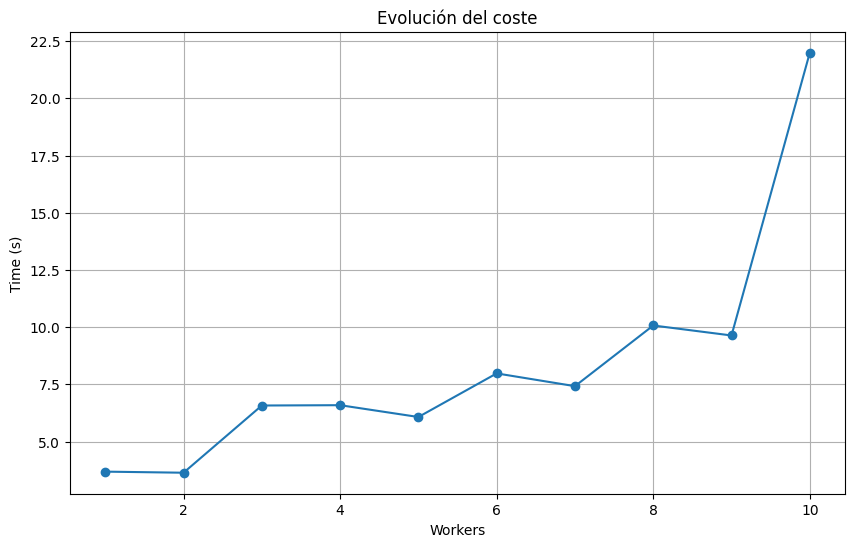

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

xs = sorted(result.keys())
ys = [result[x] for x in xs]

plt.plot(xs, ys, marker='o')   # línea + puntos
plt.xlabel("Workers")
plt.ylabel("Time (s)")
plt.title("Evolución del coste")
plt.grid(True)
plt.show()


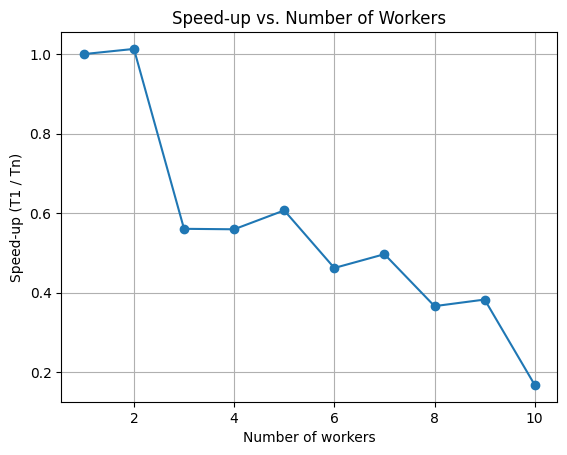

In [166]:
workers = sorted(result.keys())
t1 = result[1]  # baseline

speedup = {w: t1 / result[w] for w in workers}

# plot
plt.plot(workers, [speedup[w] for w in workers], marker="o")
plt.xlabel("Number of workers")
plt.ylabel("Speed-up (T1 / Tn)")
plt.title("Speed-up vs. Number of Workers")
plt.grid(True)
plt.show()

In [ ]:
# PRIMERA PRUEBA: NO CACHE 

In [125]:
sc.stop()

In [126]:
def readFile (filename): 
    '''Arguments: 
    filename – name of the spam dataset file 
    12 columns: 11 features/dimensions (X) + 1 column with labels (Y) 
    Y -- Train labels (0 if normal traffic, 1 if botnet)  
    m rows: number of examples (m) 
    Returns: 
    An RDD containing the data of filename. Each example (row) of the file 
    corresponds to one RDD record. Each record of the RDD is a tuple (X,y).  
    “X” is an array containing the 11 features (float number) of an example  
    “y” is the 12th column of an example (integer 0/1) '''
    result = sc.textFile(filename)
    map_result = result.map(lambda row: [float(x) for x in row.split(",")])
    rdd_xy = map_result.map(lambda row: (row[:11],row[11]))
    return rdd_xy

In [127]:
def normalize (RDD_Xy): 
    '''Arguments: 
    RDD_Xy is an RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    Returns: 
    An RDD rescaled to N(0,1) in each column (mean=0, standard deviation=1) '''
    def map_normalize (RDD_Xy): 
        result = []
        x, y = RDD_Xy
        var = broadcast_var.value
        for i, x in enumerate(x):
             mean_aux, std_aux = var[i]
             if(std_aux!=0):
                 result.append((x - mean_aux)/std_aux)
             else:
                 result.append(0.0)
        return result, y
        
    rdd_norm = RDD_Xy.map(map_normalize)
    return rdd_norm

In [128]:
# PRIMERA PRUEBA TRAIN
import numpy as np
import math

def sigmoid(z):
    if z >= 0:
        ez = math.exp(-z)
        return 1.0 / (1.0 + ez)
    else:
        ez = math.exp(z)
        return ez / (1.0 + ez)

def _sample_grad(xy, w, b):
    X, y = xy
    X = np.asarray(X, dtype=np.float64)
    y = float(y)

    z = float(np.dot(w, X) + b)
    y_hat = sigmoid(z)
    diff = y_hat - y

    grad_w = diff * X      # vector (11,)
    grad_b = diff          # escalar

    loss = -(y * math.log(y_hat)+(1-y)*math.log(1-y_hat))
    return (grad_w, grad_b, loss)

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    '''Arguments: 
    RDD_Xy --- RDD containing data examples. Each record of the RDD is a tuple 
    (X,y). 
    “X” is an array containing the 11 features (float number) of an example 
    “y” is the label of the example (integer 0/1)  
    iterations -- number of iterations of the optimization loop 
    learning_rate -- learning rate of the gradient descent 
    lambda_reg – regularization rate: l2 es el que vamos a aplicar
    
    Returns: 
    A list or array containing the weights “w” and bias “b”	at the end of the 
    training process'''	

    sc = RDD_Xy.context
    #data = RDD_Xy.cache()
    data = RDD_Xy

    m = data.count()
    if m == 0:
        raise ValueError("RDD_Xy vacío")

    k = len(data.first()[0])  # 11
    cost=[]
    # inicialización
    rng = np.random.default_rng(42)
    w = rng.normal(0, 0.01, size=k).astype(np.float64)
    b = float(rng.normal(0, 0.01))
    for i in range(iterations):
        bc_w = sc.broadcast(w)
        bc_b = sc.broadcast(b)

        # suma de gradientes por todo el dataset
        sum_grad_w, sum_grad_b, sum_loss = data.map(
            lambda xy: _sample_grad(xy, bc_w.value, bc_b.value)
        ).reduce(
            lambda a, c: (a[0] + c[0],a[1] + c[1], a[2] + c[2])
        )

        bc_w.unpersist()
        bc_b.unpersist()

        # promedio + L2
        grad_w = (sum_grad_w / m) + (lambda_reg / k) * w   # si tu rúbrica usa /k
        grad_b = (sum_grad_b / m)
        
        # update
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        reg_term = (lambda_reg / (2*k)) * float(np.dot(w,w))
        J = (sum_loss / m ) + reg_term
        #cost[i]=J
        
        print(f"Loss en iteracion {i}: {J}")

    return [w, b]

In [129]:
def accuracy (w, b, RDD_Xy): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    RDD_Xy – RDD containing examples to be predicted  
    Returns: 
    accuracy -- the number of predictions that are correct divided by the number         
    of records (examples) in RDD_xy.  
    Predict function can be used for predicting a single example'''
    pred_ok = RDD_Xy.map(
            lambda xy: 1 if predict(w, b, xy[0]) == int(xy[1]) else 0
        )
    
    correct = pred_ok.reduce(lambda a, c: a + c)
    total = RDD_Xy.count()
    return correct / total if total > 0 else 0.0

In [130]:
def predict (w, b, X): 
    '''Arguments: 
    w -- weights 
    b -- bias 
    X – Example to be predicted  
     
    Returns: 
    Y_pred – a value (0/1) corresponding to the prediction of X '''
    threshold=0.5
    z = float(np.dot(np.asarray(w, dtype=float), np.asarray(X, dtype=float)) + float(b))
    p = sigmoid(z)
    return 1 if p >= threshold else 0

In [167]:
results = []

sc = SparkContext(f"local[{i}]", f"Prueba_{i}")
data=readFile("./botnet_reduced_10k_l.csv")
rows_rdd = data.map(lambda line: line[0])
print(rows_rdd.take(1))
print()
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
print(cols_rdd.take(5))
print()
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
print(group_rdd.take(1))
print()
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
print(mean_rdd.collect())
print()
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
# standarize
data = normalize(data)
ws = train(data,10,1.5,0.0)
print(ws)
w,b = ws
acc = accuracy(w,b,data)
print("acc:",acc)
sc.stop()


[[3545.3018916840147, 3198.0139469522546, 80.00015469454229, 1.0000019205086303, 444960086.4643011, 476.8073064086366, 12.999999992936175, -7.710424743123667e-09, 87.00000148917339, 19099430.15956688, 2468368394.7593513]]

[(0, (3545.3018916840147, 12569165.503178252, 1)), (1, (3198.0139469522546, 10227293.204901138, 1)), (2, (80.00015469454229, 6400.024751150697, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (444960086.4643011, 1.979894785463183e+17, 1))]

[(0, (12803754.219009735, 42093817354.54738, 10000))]

[(0, (1280.3754219009734, np.float64(1603.1283524554865))), (2, (6731.840347965938, np.float64(16143.570758867212))), (4, (121275247.72856577, np.float64(231897601.15814963))), (6, (9.076034067369386, np.float64(5.298563791442084))), (8, (123.35245169147989, np.float64(90.51210108183089))), (10, (2265313681.7355, np.float64(1295737133.3017318))), (1, (21567.839327212547, np.float64(24184.80186045207))), (3, (60997.64689050441, np.float64(132772.42926971006))), (5, (1

Loss en iteracion 0: 0.6909301295665742
Loss en iteracion 1: 0.4026755569253437
Loss en iteracion 2: 0.3333483041534318
Loss en iteracion 3: 0.2975746829831369
Loss en iteracion 4: 0.2748372052901984
Loss en iteracion 5: 0.2588342361694671
Loss en iteracion 6: 0.24685656151816043
Loss en iteracion 7: 0.23751116060280797
Loss en iteracion 8: 0.22999599675012586
Loss en iteracion 9: 0.22381166695972524
4.716904475999399


In [ ]:
sc = SparkContext(f"local[{i}]", f"Prueba_{i}")
t0 = perf_counter()
data=readFile("./botnet_reduced_10k_l.csv")
rows_rdd = data.map(lambda line: line[0])
cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
cols_rdd.cache()
group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
# standarize
data = normalize(data)
ws = train(data,10,1.5,0.0)
w,b = ws
acc = accuracy(w,b,data)
time = perf_counter() - t0
sc.stop()

print(time)

# EJ 3.4

In [172]:
sc.stop()

In [173]:
# read data
result = {}
for i in range(1, 9): # MODIFICAR CUANDO TENGAMOS LA EJECUCION FINAL (CORES + 3)
    sc = SparkContext(f"local[{4}]", f"Prueba_{i}")
    # Ver información del SparkContext
    print(f"Master: {sc.master}")
    print(f"Default parallelism: {sc.defaultParallelism}")
    t0 = perf_counter()
    data=readFile("./botnet_reduced_10k_l.csv").repartition(i)
    print(data.getNumPartitions())
    rows_rdd = data.map(lambda line: line[0])
    print(rows_rdd.take(1))
    print()
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    print(cols_rdd.take(5))
    print()
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    print(group_rdd.take(1))
    print()
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    print(mean_rdd.collect())
    print()
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train(data,10,1.5,0.0)
    print(ws)
    w,b = ws
    acc = accuracy(w,b,data)
    print("acc:",acc)
    time = perf_counter() - t0
    result[i] = time
    sc.stop()
print(result)

Master: local[4]
Default parallelism: 4
1


[[3545.3018916840147, 3198.0139469522546, 80.00015469454229, 1.0000019205086303, 444960086.4643011, 476.8073064086366, 12.999999992936175, -7.710424743123667e-09, 87.00000148917339, 19099430.15956688, 2468368394.7593513]]

[(0, (3545.3018916840147, 12569165.503178252, 1)), (1, (3198.0139469522546, 10227293.204901138, 1)), (2, (80.00015469454229, 6400.024751150697, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (444960086.4643011, 1.979894785463183e+17, 1))]

[(0, (12803754.219010336, 42093817354.54772, 10000))]

[(0, (1280.3754219010336, np.float64(1603.1283524554492))), (1, (21567.839327213467, np.float64(24184.801860451298))), (2, (6731.840347965561, np.float64(16143.570758867018))), (3, (60997.64689050794, np.float64(132772.42926970878))), (4, (121275247.72856677, np.float64(231897601.15815005))), (5, (15681843.675553631, np.float64(44314898.9770038))), (6, (9.076034067370005, np.float64(5.298563791440585))), (7, (1.875306523382018, np.float64(2.0963027561943175))), (8, (

[[3545.3018916840147, 3198.0139469522546, 80.00015469454229, 1.0000019205086303, 444960086.4643011, 476.8073064086366, 12.999999992936175, -7.710424743123667e-09, 87.00000148917339, 19099430.15956688, 2468368394.7593513]]

[(0, (3545.3018916840147, 12569165.503178252, 1)), (1, (3198.0139469522546, 10227293.204901138, 1)), (2, (80.00015469454229, 6400.024751150697, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (444960086.4643011, 1.979894785463183e+17, 1))]

[(0, (12803754.219010105, 42093817354.54753, 10000))]

[(0, (1280.3754219010104, np.float64(1603.1283524554615))), (3, (60997.64689050493, np.float64(132772.4292697098))), (6, (9.076034067369363, np.float64(5.29856379144222))), (9, (2123967949.9252985, np.float64(723225092.6999626))), (1, (21567.839327212518, np.float64(24184.801860452062))), (4, (121275247.72856545, np.float64(231897601.15815043))), (7, (1.8753065233821056, np.float64(2.096302756194312))), (10, (2265313681.7354712, np.float64(1295737133.3017907))), (2, 

[[-1.21308761436012e-06, 2529.5994634859253, -4.410370297591726e-05, 0.9999997452701503, 138732465.28180686, 70.99999101711273, 11.999999995904211, -2.35688187855132e-08, 8.00000498340475, 2468369572.9931583, 3757374480.752986]]

[(0, (-1.21308761436012e-06, 1.471581560113927e-12, 1)), (1, (2529.5994634859253, 6398873.445668281, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138732465.28180686, 1.9246696923167744e+16, 1))]

[(0, (12803754.21901014, 42093817354.54783, 10000))]

[(0, (1280.375421901014, np.float64(1603.128352455468))), (4, (121275247.72856438, np.float64(231897601.15815097))), (8, (123.35245169147872, np.float64(90.51210108183182))), (1, (21567.83932721258, np.float64(24184.801860451935))), (5, (15681843.675553959, np.float64(44314898.97700532))), (9, (2123967949.925301, np.float64(723225092.6999605))), (2, (6731.8403479656845, np.float64(16143.570758867136))), (6, (9.076034067369436, np.float64(5.298

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219010137, 42093817354.54809, 10000))]

[(0, (1280.3754219010136, np.float64(1603.1283524554765))), (5, (15681843.675553974, np.float64(44314898.97700507))), (10, (2265313681.735475, np.float64(1295737133.3017914))), (1, (21567.839327212645, np.float64(24184.80186045185))), (6, (9.076034067369497, np.float64(5.298563791442009))), (2, (6731.840347965678, np.float64(16143.57075886716))), (7, (1.8753065233821014, np.float64(2.0963027561943157))), (3, (60997.646890508244, np.float64(132772.4292

acc: 0.9283
Master: local[4]
Default parallelism: 4
6


[[-1.21308761436012e-06, 2529.5994634859253, -4.410370297591726e-05, 0.9999997452701503, 138732465.28180686, 70.99999101711273, 11.999999995904211, -2.35688187855132e-08, 8.00000498340475, 2468369572.9931583, 3757374480.752986]]

[(0, (-1.21308761436012e-06, 1.471581560113927e-12, 1)), (1, (2529.5994634859253, 6398873.445668281, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138732465.28180686, 1.9246696923167744e+16, 1))]



[(0, (12803754.21901014, 42093817354.548035, 10000))]

[(0, (1280.375421901014, np.float64(1603.1283524554744))), (6, (9.076034067369518, np.float64(5.298563791441922))), (1, (21567.839327212703, np.float64(24184.80186045182))), (7, (1.8753065233820894, np.float64(2.0963027561943224))), (2, (6731.840347965691, np.float64(16143.570758867165))), (8, (123.35245169147916, np.float64(90.51210108182997))), (3, (60997.6468905082, np.float64(132772.42926970895))), (9, (2123967949.9253044, np.float64(723225092.6999545))), (4, (121275247.72856458, np.float64(231897601.158151))), (10, (2265313681.7354736, np.float64(1295737133.301797))), (5, (15681843.675553821, np.float64(44314898.97700515)))]

Loss en iteracion 0: 0.6909301295665746
Loss en iteracion 1: 0.4026755569253424
Loss en iteracion 2: 0.33334830415343264
Loss en iteracion 3: 0.2975746829831366
Loss en iteracion 4: 0.27483720529019906
Loss en iteracion 5: 0.25883423616946727
Loss en iteracion 6: 0.2468565615181612
Loss en iteracion 7: 0.

[[0.0006999386757797765, 61897.98817283135, 53.000260213743786, 499897.4493343788, 262.99924185046257, 82.99988759205826, 13.986787817919089, 5.000000032871429, 7.999999237579246, 1566353357.5387971, 1483612272.011435]]

[(0, (0.0006999386757797765, 4.899141498523472e-07, 1)), (1, (61897.98817283135, 3831360939.8439693, 1)), (2, (53.000260213743786, 2809.0275827245523, 1)), (3, (499897.4493343788, 249897459851.01785, 1)), (4, (262.99924185046257, 69168.6012139181, 1))]



[(0, (12803754.219010115, 42093817354.54798, 10000))]

[(0, (1280.3754219010116, np.float64(1603.1283524554744))), (7, (1.8753065233820774, np.float64(2.096302756194328))), (1, (21567.839327212718, np.float64(24184.80186045182))), (8, (123.35245169147973, np.float64(90.51210108182858))), (2, (6731.840347965698, np.float64(16143.570758867158))), (9, (2123967949.9253063, np.float64(723225092.6999432))), (3, (60997.64689050814, np.float64(132772.42926970898))), (10, (2265313681.735472, np.float64(1295737133.3018057))), (4, (121275247.72856508, np.float64(231897601.1581508))), (5, (15681843.675553707, np.float64(44314898.97700521))), (6, (9.076034067369479, np.float64(5.298563791441939)))]

Loss en iteracion 0: 0.690930129566575
Loss en iteracion 1: 0.4026755569253418
Loss en iteracion 2: 0.3333483041534323
Loss en iteracion 3: 0.29757468298313644
Loss en iteracion 4: 0.2748372052901989
Loss en iteracion 5: 0.2588342361694671
Loss en iteracion 6: 0.24685656151816102
Loss en iteracion 7: 0.

Loss en iteracion 8: 0.22999599675012614
Loss en iteracion 9: 0.22381166695972574
[array([-0.30372989, -0.82410725, -0.32764508, -0.18718418, -1.14532131,
        0.74152177,  0.17930694, -1.09138574,  0.47564036,  0.66662877,
        0.56159121]), -0.08376823025447692]
acc: 0.9283
Master: local[4]
Default parallelism: 4
8


[[434.2353517464801, 50104.37658203492, 53.000260213743786, 1.0000019205086303, 262.99924185046257, 85.99984003990357, 12.999999992936175, 2.999999985175615, 7.999999237579246, 2468369631.949106, 1427612372.1857076]]

[(0, (434.2353517464801, 188560.34070638928, 1)), (1, (50104.37658203492, 2510448552.6743693, 1)), (2, (53.000260213743786, 2809.0275827245523, 1)), (3, (1.0000019205086303, 1.000003841020949, 1)), (4, (262.99924185046257, 69168.6012139181, 1))]

[(0, (12803754.219010087, 42093817354.54792, 10000))]

[(0, (1280.3754219010086, np.float64(1603.1283524554751))), (8, (123.35245169148021, np.float64(90.51210108182785))), (1, (21567.839327212718, np.float64(24184.80186045182))), (9, (2123967949.9253078, np.float64(723225092.699929))), (2, (6731.840347965707, np.float64(16143.570758867154))), (10, (2265313681.7354703, np.float64(1295737133.3018079))), (3, (60997.64689050811, np.float64(132772.42926970895))), (4, (121275247.72856556, np.float64(231897601.1581506))), (5, (15681843

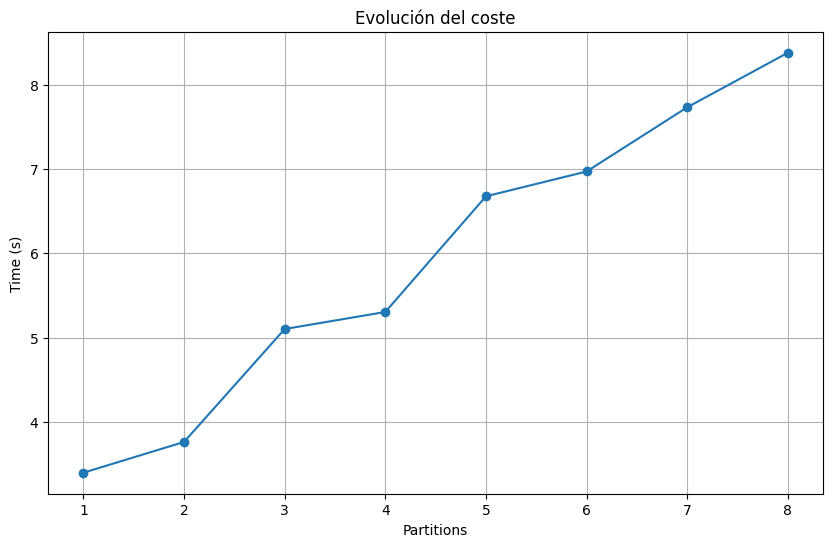

In [171]:
plt.figure(figsize=(10, 6))

xs = sorted(result.keys())
ys = [result[x] for x in xs]

plt.plot(xs, ys, marker='o')   # línea + puntos
plt.xlabel("Partitions")
plt.ylabel("Time (s)")
plt.title("Evolución del coste")
plt.grid(True)
plt.show()

# EJ 3.5

In [174]:
sc.stop()

In [175]:
# read data
result = {}
for i in range(1, 11): # MODIFICAR CUANDO TENGAMOS LA EJECUCION FINAL (CORES + 3)
    sc = SparkContext(f"local[{i}]", f"Prueba_{i}")
    t0 = perf_counter()
    data=readFile("./botnet_reduced_10k_l.csv").repartition(2)
    print(data.getNumPartitions())
    rows_rdd = data.map(lambda line: line[0])
    print(rows_rdd.take(1))
    print()
    cols_rdd = rows_rdd.flatMap(lambda row: [(i, (x,x*x, 1)) for i, x in enumerate(row)])
    print(cols_rdd.take(5))
    print()
    group_rdd = cols_rdd.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1],a[2]+b[2]))
    print(group_rdd.take(1))
    print()
    mean_rdd = group_rdd.map(lambda t: (t[0],(t[1][0] / t[1][2], np.sqrt((t[1][1] / t[1][2]) - (t[1][0] / t[1][2])**2))))
    print(mean_rdd.collect())
    print()
    broadcast_var = sc.broadcast(dict(mean_rdd.collect()))
    # standarize
    data = normalize(data)
    ws = train(data,10,1.5,0.0)
    print(ws)
    w,b = ws
    acc = accuracy(w,b,data)
    print("acc:",acc)
    time = perf_counter() - t0
    result[i] = time
    sc.stop()
print(result)

2
[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.4292

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

[[3589.5014175397446, 16718.379413427894, -4.410370297591726e-05, 0.9999997452701503, 138724436.1515659, 58259300.49627323, 11.999999995904211, -2.35688187855132e-08, 199.00000192395984, 2468369600.009986, 2468368392.7377276]]

[(0, (3589.5014175397446, 12884520.426519835, 1)), (1, (16718.379413427894, 279504210.21132964, 1)), (2, (-4.410370297591726e-05, 1.9451366161879328e-09, 1)), (3, (0.9999997452701503, 0.9999994905403655, 1)), (4, (138724436.1515659, 1.924446918556989e+16, 1))]

[(0, (12803754.219009738, 42093817354.54738, 10000))]

[(0, (1280.3754219009738, np.float64(1603.128352455486))), (2, (6731.8403479659455, np.float64(16143.570758867207))), (4, (121275247.72856542, np.float64(231897601.1581495))), (6, (9.076034067369397, np.float64(5.298563791442073))), (8, (123.35245169148003, np.float64(90.51210108183076))), (10, (2265313681.735502, np.float64(1295737133.3017306))), (1, (21567.83932721253, np.float64(24184.80186045216))), (3, (60997.64689050455, np.float64(132772.429269

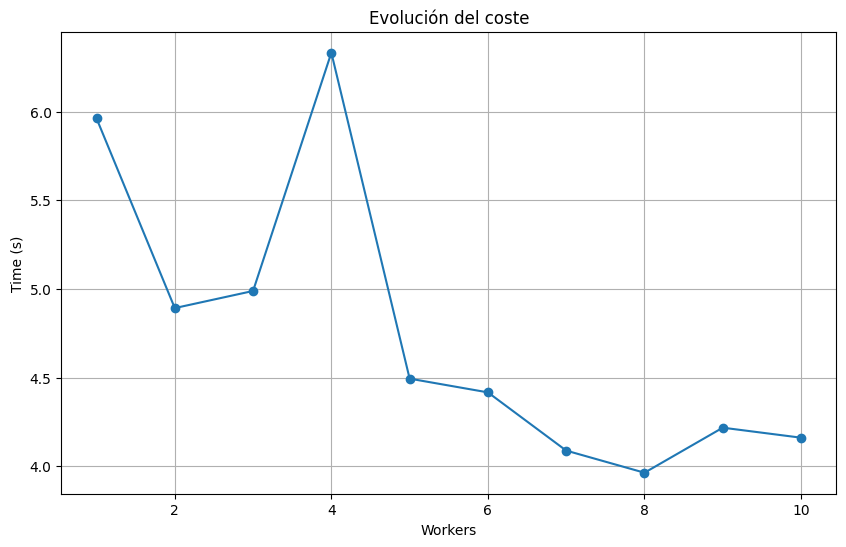

In [177]:
plt.figure(figsize=(10, 6))

xs = sorted(result.keys())
ys = [result[x] for x in xs]

plt.plot(xs, ys, marker='o')   # línea + puntos
plt.xlabel("Workers")
plt.ylabel("Time (s)")
plt.title("Evolución del coste")
plt.grid(True)
plt.show()

In [114]:
# read data
data=readFile(path)

# standarize
data = normalize(data)
num_blocks_cv=10

# shuffle rows and transform data, specifying the number of blocks
data_cv = transform(data,num_blocks_cv)

for i in range(num_blocks_cv):
    tr_data,test_data=get_block_data(data_cv,i)
    
    ws = train(data,nIter,learningRate)
    acc = accuracy(data,ws)
    print("acc:",acc)

print("average acc:" avg_acc)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (641485667.py, line 18)

In [14]:
sc.stop()